# 오늘의 날씨
> <strong>설명</strong>  
> 오늘의 날씨 (기온, 날씨, 강수여부)를 지도에 표시합니다.  
> 업데이트 : 기상청 API 로부터 실시간으로 업데이트하며, 측정 기준시각은 요청일 새벽 2시입니다.  

  
> <strong>사용 데이터</strong>  
>(1) 날씨 수집 지역 데이터 : `todays_forecast.xlsx`  
>(2) 아이콘 정보 : https://dailyheumsi.tistory.com/85  
>(3) 예보 정보 : 기상청 데이터 (https://www.data.go.kr/data/15084084/openapi.do)  


* TO DO  
(1) 저작자 표시 필요

## 기본 import

In [1]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from folium import plugins
from folium.features import CustomIcon

## 기상청 API 연동

### 기상청 API 연동 정보 (단기)

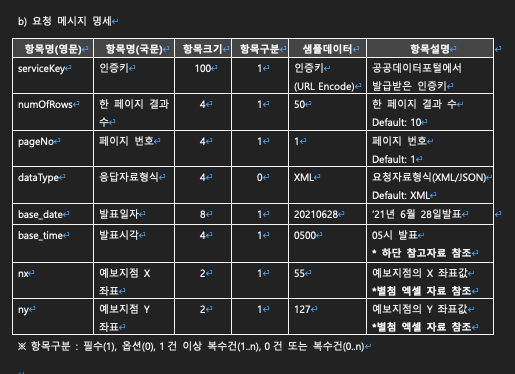  
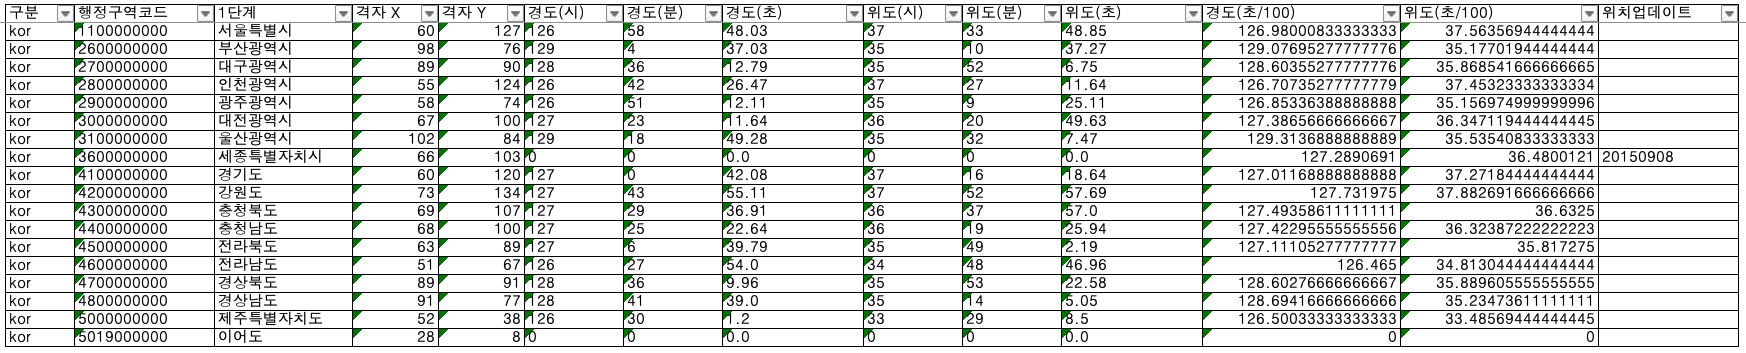  
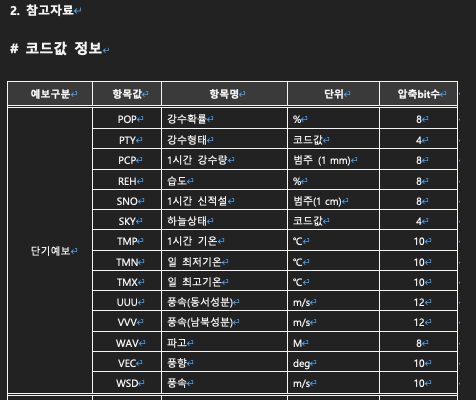  
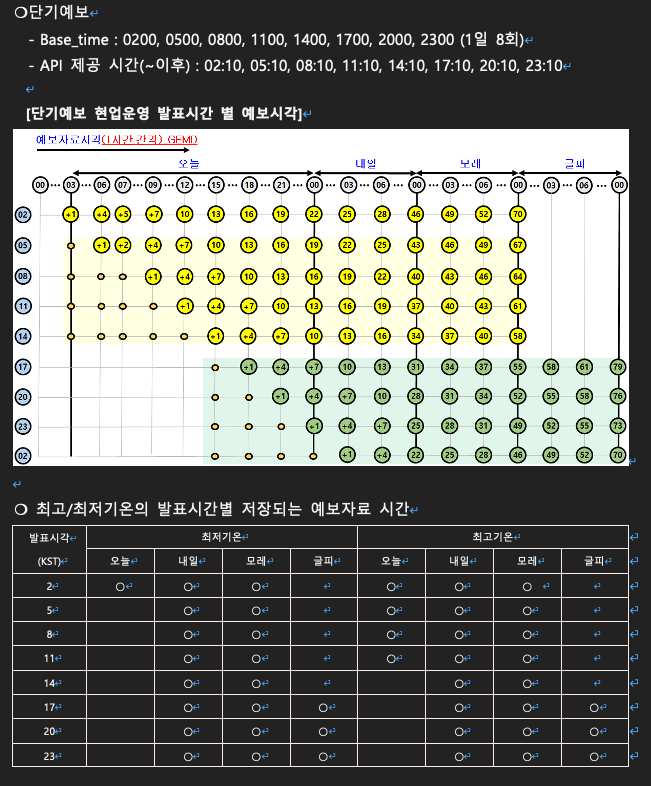  
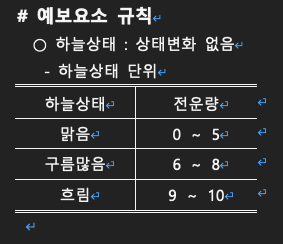  

### 기상청 API 연동 함수 생성

In [21]:
# 기상청 API 연동
## API 함수 지정

def forecast(base_date, base_time, nx, ny):
    
    '''
    * 함수 소개
    기상청 API로부터 기상 예보 불러오기
    반환 데이터 : JSON 파일
    
    * 파라미터 소개
    (1) base_date = str / (필수) 측정일자 : YYYYMMDD eg. '20221123'
    (2) base_time = str / (필수) 측정시간 : hhmm eg. '0500'
    (3) nx = str / (필수) 예보지점 x 좌표값 (참고 : https://www.data.go.kr/data/15084084/openapi.do)
    (4) ny = str / (필수) 예보지점 y 좌표값 (참고 : https://www.data.go.kr/data/15084084/openapi.do)
    
    * 주요 키값
    (1) baseDate : 측정 일자 (str)
    (2) baseTime : 측정 시각 (str)
    (3) fcstDate : 예보 일자 (str)
    (4) fcstTime : 예보 시간 (str)
    (5) category : 측정 정보 (범주)
    (6) fcstValue : 측정 값 (category에 따라 다름)
    
    * category 구분
    (1) tmn 일 최저기온 (float형 데이터)
    (2) tmx 일 최고기온 (float형 데이터)
    (3) sky 하늘상태 (int형 데이터)
    (4) pcp 강수량 (범주형 데이터)
    
    * 사용 예시
    forecast('20221122', '0200', '60', '127')
    '''
    import requests
    import json
    
    serviceKey = 'Ti7sOzQAPf/O8pqQQz5eEfDzHNzNhK0t+dVyZ4O+XZ6oF1FHMBVnryrcKCvkkKCENlyVt/rHerMs3vKVrPOLLg==' #API 키
    pageNo = '1' #기본 노출 페이지 번호 : eg. '1'
    numOfRows = '1000' # 한 페이지 당 결과 수 : eg. '10'
    dataType = 'JSON' # 응답 데이터 타입 : JSON / XML
    base_date = base_date # 발표일자 : YYYYMMDD eg. '20221123'
    base_time = base_time # 발표시간 : hhmm eg. '0500'
    nx = nx # 예보지점 x 좌표값
    ny = ny # 예보지점 y 좌표값
    
    url = 'http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst'
    params ={'serviceKey' : serviceKey, 'pageNo' : pageNo, 'numOfRows' : numOfRows, 'dataType' : dataType, 'base_date' : base_date, 'base_time' : base_time, 'nx' : nx, 'ny' : ny }
    
    ## 데이터 응답
    response = requests.get(url, params=params)
    
    ## 리턴값
    return response.json()

### 기상예보 API JSON 데이터 추출 함수 생성

In [22]:
# JSON 추출 함수

def forecast_extract(fcstDate, nx, ny) :
    '''
    * 파라미터
    (1) fcstDate = 예보 일자
    (2) nx = 예보지점 x 좌표값
    (3) ny = 예보지점 y 좌표값
    
    * 반환값
    (1) tmn : 최저기온
    (2) tmx : 최고기온 
    (3) sky_morning : 오전하늘
    (4) sky_evening : 오후하늘
    (5) pcp_morning : 오전강수량
    (6) pcp_evening : 오후강수량
    '''
    base_date = f'{fcstDate}'
    base_time = '0200'
    data = forecast(base_date, base_time, nx, ny)['response']['body']['items']['item']
    
    # 변수
    
    tmn = 0.0
    tmx = 0.0
    sky_morning = 0
    sky_evening = 0
    pcp_morning = ''
    pcp_evening = ''
    
    for i in data:
        if i.get('fcstDate') == fcstDate and i.get('category') == 'TMN':
            tmn = i.get('fcstValue')
        if i.get('fcstDate') == fcstDate and i.get('category') == 'TMX':
            tmx = i.get('fcstValue')
        if i.get('fcstDate') == fcstDate and i.get('category') == 'SKY' and i.get('fcstTime') == '0600':
            sky_morning = i.get('fcstValue')
        if i.get('fcstDate') == fcstDate and i.get('category') == 'SKY' and i.get('fcstTime') == '1700':
            sky_evening = i.get('fcstValue')
        if i.get('fcstDate') == fcstDate and i.get('category') == 'PCP' and i.get('fcstTime') == '0500':
            pcp_morning = i.get('fcstValue')
        if i.get('fcstDate') == fcstDate and i.get('category') == 'PCP' and i.get('fcstTime') == '1700':
            pcp_evening = i.get('fcstValue')
    
    forecast_set = {'최저기온':tmn, '최고기온':tmx,
                    '하늘상태_오전':sky_morning, '하늘상태_오후':sky_evening,
                    '강수량_오전':pcp_morning, '강수량_오후':pcp_evening}
    
    return forecast_set

In [23]:
#dicttest
dictest = [{'a':123, 'b':123, 'v':123}, {'a':456, 'b':123, 'v':123}]
a = [i for i in dictest if i.get('a') == 123 and i.get('b') == 123 and i.get('v') == 123]
a
# for i in dictest:
#     print(i.get('a'))

[{'a': 123, 'b': 123, 'v': 123}]

## 오늘의 기상정보 불러오기

### 기상예보 Data Frame 생성

In [25]:
# 기상예보 Data Frame

## forecast_table CSV 불러오기 (지역명, xy좌표, 위경도값)
forecast_xy_table = pd.read_csv('forecast_xy_table.csv', encoding='utf-8')

## 관측값 넣을 데이터프레임 생성
df_forecast = pd.DataFrame(forecast_xy_table[['지역명', '격자 X', '격자 Y', '경도', '위도']])

## 관측값 넣을 칼럼 생성
df_forecast['예보일자'] = pd.Series(np.zeros((17,), dtype=str), dtype=str) # fcstDate
df_forecast['최저기온'] = pd.Series(np.zeros((17,), dtype=float), dtype=float) # tmn 일 최저기온 (float형 데이터)
df_forecast['최고기온'] = pd.Series(np.zeros((17,), dtype=float), dtype=float) # tmx 일 최고기온 (float형 데이터)
df_forecast['하늘상태_오전'] = pd.Series(np.zeros((17,), dtype=int), dtype=int) # sky 하늘상태 (int형 데이터)
df_forecast['하늘상태_오후'] = pd.Series(np.zeros((17,), dtype=int), dtype=int) # sky 하늘상태 (int형 데이터)
df_forecast['강수량_오전'] = pd.Series(np.zeros((17,), dtype=str), dtype=str) # pcp 강수량 (범주형 데이터)
df_forecast['강수량_오후'] = pd.Series(np.zeros((17,), dtype=str), dtype=str) # pcp 강수량 (범주형 데이터)
df_forecast['미세먼지'] = pd.Series(np.zeros((17,), dtype=str), dtype=str) # 미세먼지 데이터
df_forecast['위경도'] = [[df_forecast['위도'][i], df_forecast['경도'][i]] for i in range(len(df_forecast.index))]

df_forecast

,지역명,격자 X,격자 Y,경도,위도,예보일자,최저기온,최고기온,하늘상태_오전,하늘상태_오후,강수량_오전,강수량_오후,미세먼지,위경도
0,서울특별시,60,127,126.980008,37.563569,,0.0,0.0,0,0,,,,"[37.56356944444444, 126.98000833333332]"
1,부산광역시,98,76,129.076953,35.177019,,0.0,0.0,0,0,,,,"[35.17701944444444, 129.07695277777776]"
2,대구광역시,89,90,128.603553,35.868542,,0.0,0.0,0,0,,,,"[35.868541666666665, 128.60355277777776]"
3,울산광역시,102,84,129.313689,35.535408,,0.0,0.0,0,0,,,,"[35.53540833333333, 129.3136888888889]"
4,경기도,60,120,127.011689,37.271844,,0.0,0.0,0,0,,,,"[37.27184444444444, 127.01168888888888]"
5,강원도,73,134,127.731975,37.882692,,0.0,0.0,0,0,,,,"[37.882691666666666, 127.731975]"
6,충청북도,69,107,127.493586,36.632500,,0.0,0.0,0,0,,,,"[36.6325, 127.49358611111111]"
7,충청남도,68,100,127.422956,36.323872,,0.0,0.0,0,0,,,,"[36.32387222222223, 127.42295555555556]"
8,전라북도,63,89,127.111053,35.817275,,0.0,0.0,0,0,,,,"[35.817275, 127.11105277777776]"
9,전라남도,51,67,126.465000,34.813044,,0.0,0.0,0,0,,,,"[34.813044444444444, 126.465]"


### DataFrame에 예보정보 넣기

In [28]:

list_dust = [29,19,19,9,30,17,33,38,47,21,17,17,17,17,17]


def forecast_date(fcstDate):
    
    '''
    fcstDate = YYYYMMDD
    '''
    
    fcstDate = fcstDate
    nx = ''
    ny = ''

    for i in range(len(df_forecast.index)):
        nx = df_forecast['격자 X'][i]
        ny = df_forecast['격자 Y'][i]
        forset = forecast_extract(fcstDate, nx, ny)

        df_forecast['예보일자'][i] = fcstDate
        df_forecast['최저기온'][i] = forset.get('최저기온')
        df_forecast['최고기온'][i] = forset.get('최고기온')
        df_forecast['하늘상태_오전'][i] = forset.get('하늘상태_오전')
        df_forecast['하늘상태_오후'][i] = forset.get('하늘상태_오후')
        df_forecast['강수량_오전'][i] = forset.get('강수량_오전')
        df_forecast['강수량_오후'][i] = forset.get('강수량_오후')

## 지도 생성

### 일기예보 기본 지도 생성

In [39]:
# 맵 생성 (대한민국)

import folium
m = folium.Map([35.815669,127.7865791], zoom_start=7)

# 일기예보 지역 리스트
region = []
for i in range(len(df_forecast.index)):
    region.append({"name" : df_forecast['지역명'][i], 'loc' : [df_forecast['위도'][i], df_forecast['경도'][i]]})
df_forecast['미세먼지'] = [ int(i) for i in list_dust]
# 검토
m, region

(<folium.folium.Map at 0x1e309268460>,
 [{'name': '서울특별시', 'loc': [37.56356944444444, 126.98000833333332]},
  {'name': '부산광역시', 'loc': [35.17701944444444, 129.07695277777776]},
  {'name': '대구광역시', 'loc': [35.868541666666665, 128.60355277777776]},
  {'name': '울산광역시', 'loc': [35.53540833333333, 129.3136888888889]},
  {'name': '경기도', 'loc': [37.27184444444444, 127.01168888888888]},
  {'name': '강원도', 'loc': [37.882691666666666, 127.731975]},
  {'name': '충청북도', 'loc': [36.6325, 127.49358611111111]},
  {'name': '충청남도', 'loc': [36.32387222222223, 127.42295555555556]},
  {'name': '전라북도', 'loc': [35.817275, 127.11105277777776]},
  {'name': '전라남도', 'loc': [34.813044444444444, 126.465]},
  {'name': '경상북도', 'loc': [35.889605555555555, 128.60276666666667]},
  {'name': '경상남도', 'loc': [35.23473611111111, 128.69416666666666]},
  {'name': '제주특별자치도', 'loc': [33.48569444444445, 126.50033333333332]},
  {'name': '태백시', 'loc': [37.161227777777775, 128.98799722222222]},
  {'name': '강릉시', 'loc': [37.749136111

### 일기예보 지도 생성 함수

In [35]:
# 요청사항 받기


def forecast_map():
    req = input('예보 항목을 입력하세요(번호) :  ' + '\n' + '(1.최저기온/2.최고기온/3.하늘상태_오전/4.하늘상태_오후/5.강수량_오전/6.강수량_오후/7.미세먼지)')
    m = folium.Map([35.815669,127.7865791], zoom_start=7)

    # 단축번호 풀이
    req_list = ['','최저기온','최고기온','하늘상태_오전','하늘상태_오후','강수량_오전','강수량_오후', '미세먼지']
    req = req_list[int(req)]
    cus_icon =''

    # 맵 생성
    ## 기온 : folium 의 plugin 모듈 - BeautifulIcon 사용
    ## 날씨 : folium.features 의 CustomIcon 모듈 사용
    ## 요청에 따른 아이콘 매칭
    for i in range(len(df_forecast.index)):

        if req == '최저기온':
            icon = plugins.BeautifyIcon(icon_size=60, border_color='#00ABDC',
                                        text_color='#00ABDC', number=df_forecast[req][i],
                                        inner_icon_style='margin-top:0;')
        elif req == '최고기온':
            icon = plugins.BeautifyIcon(icon_size=60, border_color='#F15F5F',
                                        text_color='#F15F5F', number=df_forecast[req][i],
                                        inner_icon_style='margin-top:0;')
        elif req == '하늘상태_오전':
            if int(df_forecast[req][i]) < 4:
                cus_icon = 'icon/sky_day_good.png'
            elif int(df_forecast[req][i]) < 8:
                cus_icon = 'icon/sky_day_mid.png'
            else :
                cus_icon = 'icon/sky_day_bad.png'
            icon = CustomIcon(cus_icon, icon_size=(50,50))

        elif req == '하늘상태_오후':
            if int(df_forecast[req][i]) < 4:
                cus_icon = 'icon/sky_nig_good.png'
            elif int(df_forecast[req][i]) < 8:
                cus_icon = 'icon/sky_nig_mid.png'
            else :
                cus_icon = 'icon/sky_nig_bad.png'
            icon = CustomIcon(cus_icon, icon_size=(50,50))

        elif req == '강수량_오전':
            if df_forecast[req][i] == '강수없음':
                if int(df_forecast['하늘상태_오전'][i]) < 4:
                    cus_icon = 'icon/sky_day_good.png'
                elif int(df_forecast['하늘상태_오전'][i]) < 8:
                    cus_icon = 'icon/sky_day_mid.png'
                else :
                    cus_icon = 'icon/sky_day_bad.png'
            else :
                cus_icon = 'icon/rain.png'
            icon = CustomIcon(cus_icon, icon_size=(50,50))

        elif req == '강수량_오후':
            if df_forecast[req][i] == '강수없음':
                if int(df_forecast['하늘상태_오후'][i]) < 4:
                    cus_icon = 'icon/sky_nig_good.png'
                elif int(df_forecast['하늘상태_오후'][i]) < 8:
                    cus_icon = 'icon/sky_nig_mid.png'
                else :
                    cus_icon = 'icon/sky_nig_bad.png'
            else :
                cus_icon = 'icon/rain.png'
            icon = CustomIcon(cus_icon, icon_size=(50,50))
        
        elif req == '미세먼지':
            icon = plugins.BeautifyIcon(icon_size=60, border_color='#ffcc33',
                                        text_color='#ffcc33', number=df_forecast[req][i],
                                        inner_icon_style='margin-top:0;')
        
        
        # 마커 추가
        folium.Marker(df_forecast['위경도'][i], icon=icon).add_to(m)
        
    return m

## 최종 결과물 : 일기예보 지도 생성

In [31]:
date = input('일기예보 날짜를 입력해주세요 (YYYYMMDD)')
print('자료를 불러오는 중입니다. (10~20초 소요)')
forecast_date(date)
print('★★★자료가 준비됐습니다. 다음 코드를 실행해주세요.★★★')

일기예보 날짜를 입력해주세요 (YYYYMMDD) 20221123


자료를 불러오는 중입니다. (10~20초 소요)


C:\Users\user\AppData\Local\Temp\ipykernel_8996\3327431473.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast['예보일자'][i] = fcstDate
C:\Users\user\AppData\Local\Temp\ipykernel_8996\3327431473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast['최저기온'][i] = forset.get('최저기온')
C:\Users\user\AppData\Local\Temp\ipykernel_8996\3327431473.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast['최고기온'][i] = 

★★★자료가 준비됐습니다. 다음 코드를 실행해주세요.★★★


In [40]:


df_forecast

,지역명,격자 X,격자 Y,경도,위도,예보일자,최저기온,최고기온,하늘상태_오전,하늘상태_오후,강수량_오전,강수량_오후,미세먼지,위경도
0,서울특별시,60,127,126.980008,37.563569,20221123,9.0,16.0,4,1,강수없음,강수없음,29,"[37.56356944444444, 126.98000833333332]"
1,부산광역시,98,76,129.076953,35.177019,20221123,13.0,20.0,4,3,1.0mm,강수없음,19,"[35.17701944444444, 129.07695277777776]"
2,대구광역시,89,90,128.603553,35.868542,20221123,10.0,18.0,4,4,강수없음,강수없음,19,"[35.868541666666665, 128.60355277777776]"
3,울산광역시,102,84,129.313689,35.535408,20221123,11.0,18.0,4,4,강수없음,강수없음,9,"[35.53540833333333, 129.3136888888889]"
4,경기도,60,120,127.011689,37.271844,20221123,9.0,16.0,4,1,강수없음,강수없음,30,"[37.27184444444444, 127.01168888888888]"
5,강원도,73,134,127.731975,37.882692,20221123,7.0,16.0,4,3,강수없음,강수없음,17,"[37.882691666666666, 127.731975]"
6,충청북도,69,107,127.493586,36.632500,20221123,9.0,16.0,4,3,강수없음,강수없음,33,"[36.6325, 127.49358611111111]"
7,충청남도,68,100,127.422956,36.323872,20221123,8.0,15.0,4,1,강수없음,강수없음,38,"[36.32387222222223, 127.42295555555556]"
8,전라북도,63,89,127.111053,35.817275,20221123,10.0,16.0,4,3,강수없음,강수없음,47,"[35.817275, 127.11105277777776]"
9,전라남도,51,67,126.465000,34.813044,20221123,11.0,16.0,4,1,강수없음,강수없음,21,"[34.813044444444444, 126.465]"


In [41]:
forecast_map()

예보 항목을 입력하세요(번호) :  
(1.최저기온/2.최고기온/3.하늘상태_오전/4.하늘상태_오후/5.강수량_오전/6.강수량_오후/7.미세먼지) 7


TypeError: Object of type int64 is not JSON serializable